/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


<Quantity 277.69230769 mm>

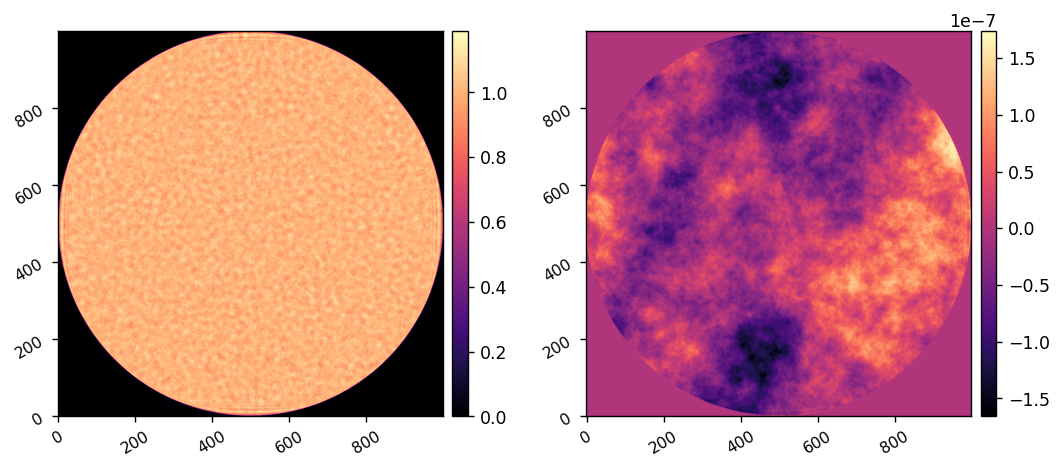

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fresnel_coro_1 as fresnel
from apra_pop_models import fresnel_ote
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
import apra_pop_models.props as props
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc
from apra_pop_models.imshows import *

model = fresnel.CORO()

FN = 500
optimal_dm1_dm2 = (model.pupil_diam**2/(model.wavelength_c*FN)).to(u.mm)
display(optimal_dm1_dm2)

ote_pupil = fits.getdata('../wfe-data/telescope_wfe.fits')
imshow2(ote_pupil[0], ote_pupil[1])


In [2]:
0.3*68

20.4

In [8]:
68 * 19.2/20.4

64.0

In [6]:
34 * 9.6/10.2

32.0

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Propagating wavelength 650.000 nm.
PSF calculated in 0.358s
0.0055000132157508414


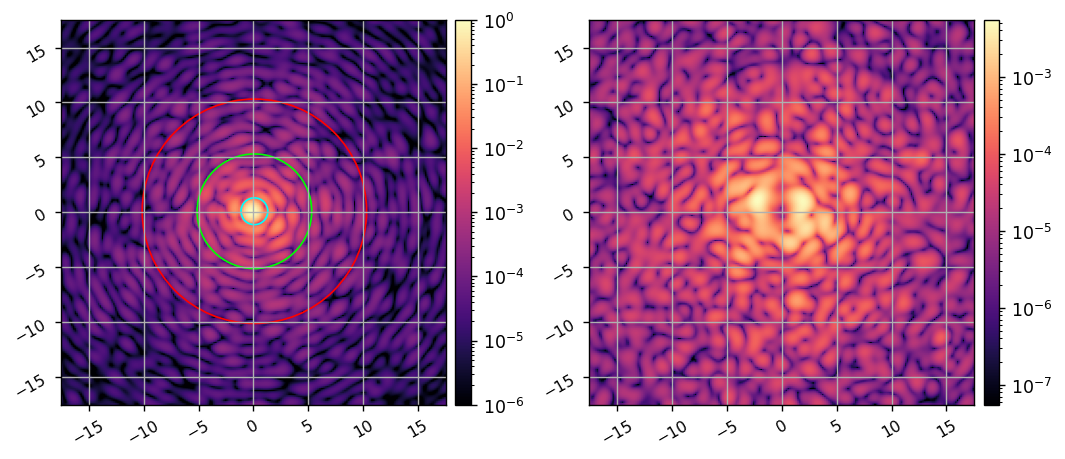

In [2]:
reload(fresnel)
reload(apra_pop_models.props)
model = fresnel.CORO()
model.npsf = 200
model.WFE.amplitude = ote_pupil[0]
model.WFE.opd = ote_pupil[1]
model.use_opds = True

model.Imax_ref = xp.max(model.snap())

pup_ratio = model.pupil_diam.to_value(u.m)/model.dm_active_diam.to_value(u.m)
xpp = (xp.arange(-model.Nact//2, model.Nact//2) + 1/2)/pup_ratio/0.9
ppx, ppy = xp.meshgrid(xpp,xpp)
amp = 5e-8
separation = 3
comm1 = amp*xp.cos(2*np.pi*(ppx + ppy)*separation/model.Nact)*xp.array(model.dm_mask)
comm2 = amp*xp.cos(2*np.pi*(ppx - ppy)*separation/model.Nact)*xp.array(model.dm_mask)
# model.set_dm1(ensure_np_array(comm1))
# model.set_dm2(ensure_np_array(comm2))

ref_psf = model.snap()

model.use_fpm = True

wfs = model.calc_wfs()
im = wfs[-1].intensity
print(xp.max(im))
imshow2(ref_psf, im, lognorm=True, vmin1=1e-6, vmin2=xp.max(im)/1e5,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'), 
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 5.22, fill=False, color='lime'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 10.22, fill=False, color='red')])


In [18]:
gs = axs[0, 0].get_gridspec()
gs

GridSpec(2, 5)

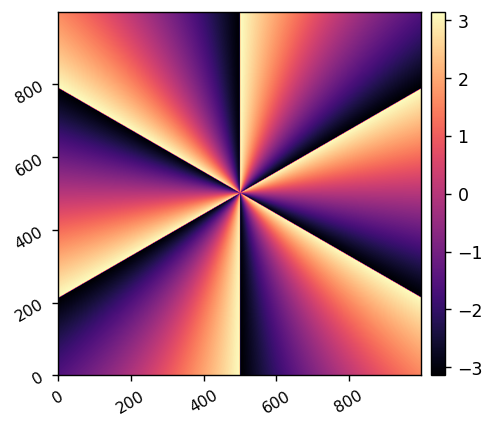

In [3]:
vortex_mask = props.make_vortex_phase_mask(1000)
imshow1(xp.angle(vortex_mask))

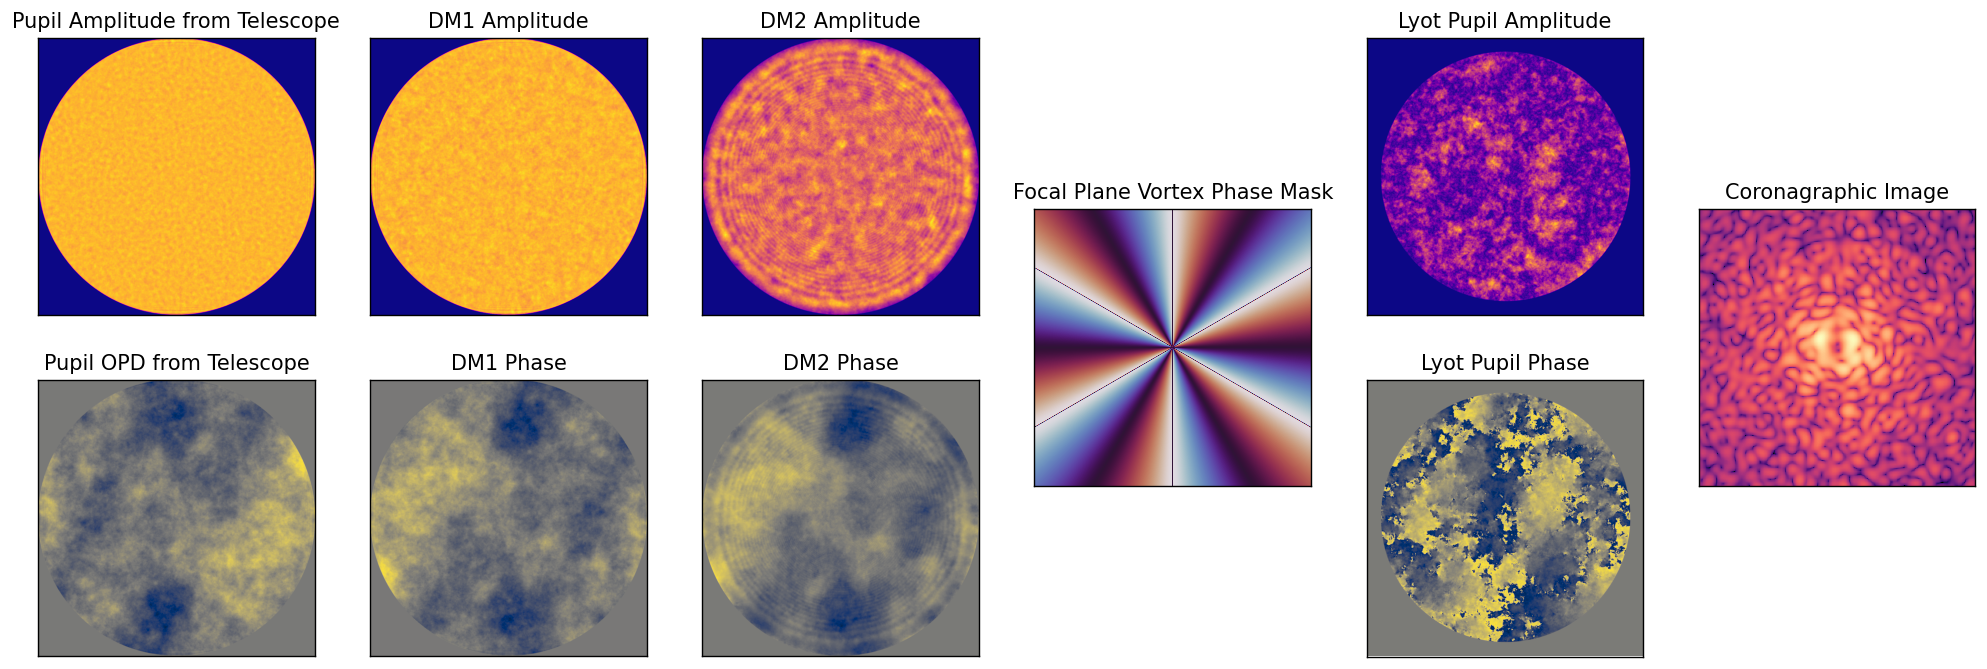

In [5]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(20,10), dpi=125)
gs = GridSpec(2, 6, figure=fig)

# Pupil WFE
ax = fig.add_subplot(gs[0, 0])
ax.imshow(ensure_np_array(model.WFE.amplitude), cmap='plasma')
ax.set_title('Pupil Amplitude from Telescope')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[1, 0])
ax.imshow(ensure_np_array(model.WFE.opd), cmap='cividis')
ax.set_title('Pupil OPD from Telescope')
ax.set_xticks([])
ax.set_yticks([])

# DM1 WFE
ax = fig.add_subplot(gs[0, 1])
ax.imshow(ensure_np_array(model.APERTURE.amplitude * utils.pad_or_crop(wfs[7].amplitude, model.npix)), cmap='plasma')
ax.set_title('DM1 Amplitude')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[1, 1])
ax.imshow(ensure_np_array(model.APERTURE.amplitude * utils.pad_or_crop(wfs[7].phase, model.npix)), cmap='cividis')
ax.set_title('DM1 Phase')
ax.set_xticks([])
ax.set_yticks([])

# DM2 WFE
ax = fig.add_subplot(gs[0, 2])
ax.imshow(ensure_np_array(model.APERTURE.amplitude * utils.pad_or_crop(wfs[8].amplitude, model.npix)), cmap='plasma')
ax.set_title('DM2 Amplitude')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[1, 2])
ax.imshow(ensure_np_array(model.APERTURE.amplitude * utils.pad_or_crop(wfs[8].phase, model.npix)), cmap='cividis')
ax.set_title('DM2 Phase')
ax.set_xticks([])
ax.set_yticks([])

# vortex phase mask
ax = fig.add_subplot(gs[:, 3])
ax.imshow(ensure_np_array(xp.angle(vortex_mask)), cmap='twilight')
ax.set_title('Focal Plane Vortex Phase Mask')
ax.set_xticks([])
ax.set_yticks([])

# Lyot Pupil
ax = fig.add_subplot(gs[0, 4])
ax.imshow(ensure_np_array(utils.pad_or_crop(wfs[24].amplitude, model.npix)), cmap='plasma')
ax.set_title('Lyot Pupil Amplitude')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(gs[1, 4])
ax.imshow(ensure_np_array(model.LYOT.amplitude * utils.pad_or_crop(wfs[24].phase, model.npix)), cmap='cividis')
ax.set_title('Lyot Pupil Phase')
ax.set_xticks([])
ax.set_yticks([])

# Pupil WFE
ax = fig.add_subplot(gs[:, 5])
ax.imshow(ensure_np_array(im), norm=LogNorm(vmin=1e-8), cmap='magma')
ax.set_title('Coronagraphic Image',)
ax.set_xticks([])
ax.set_yticks([])

plt.subplots_adjust(hspace=-0.45)
# fig.suptitle('Coronagraph Optical Train')

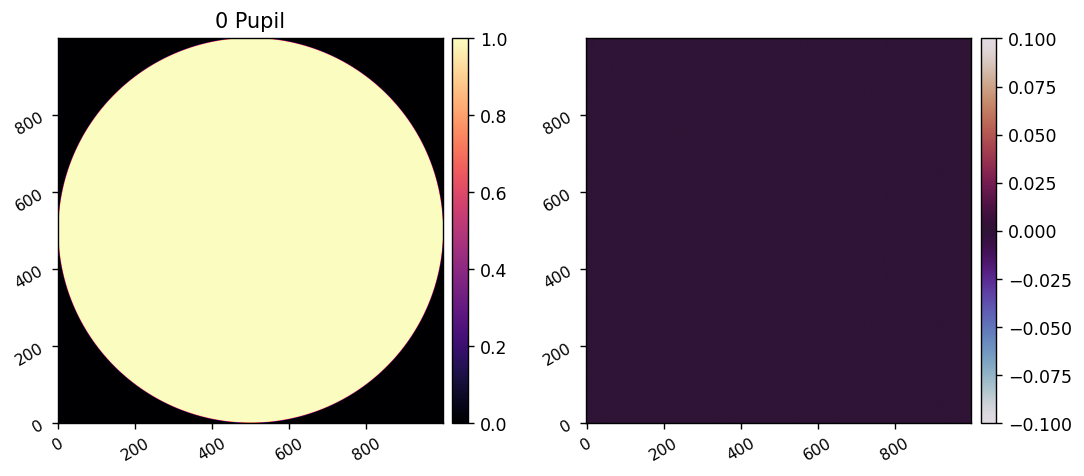

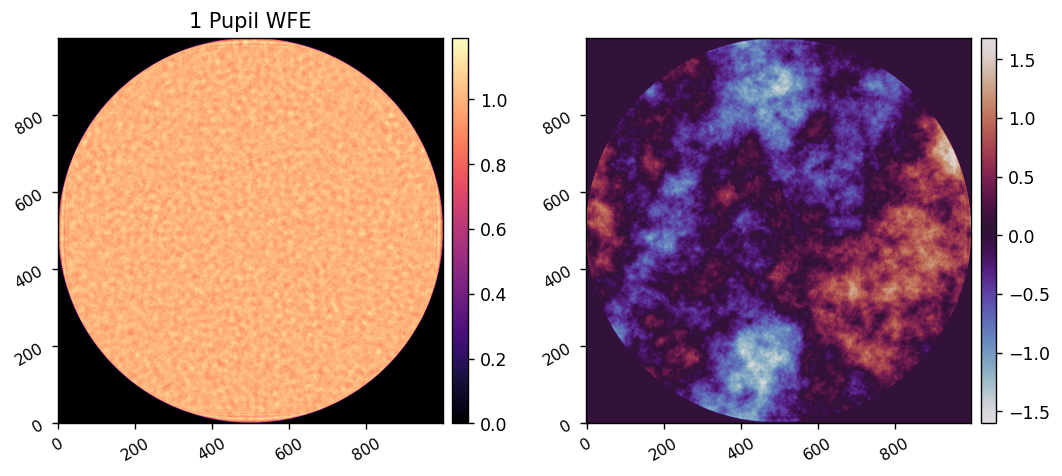

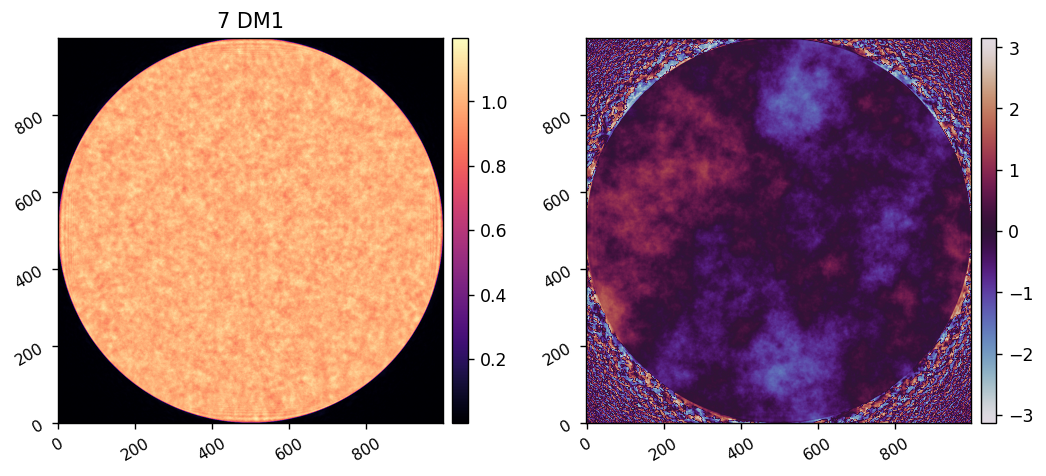

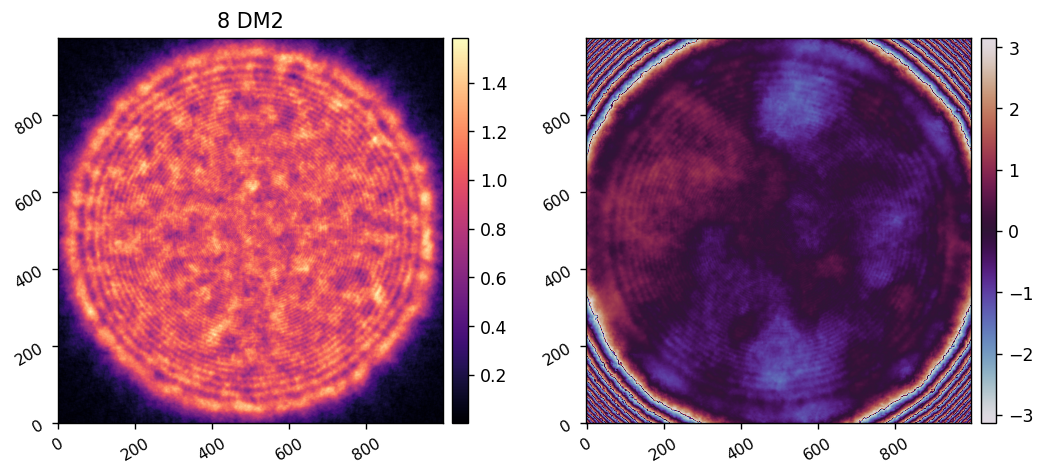

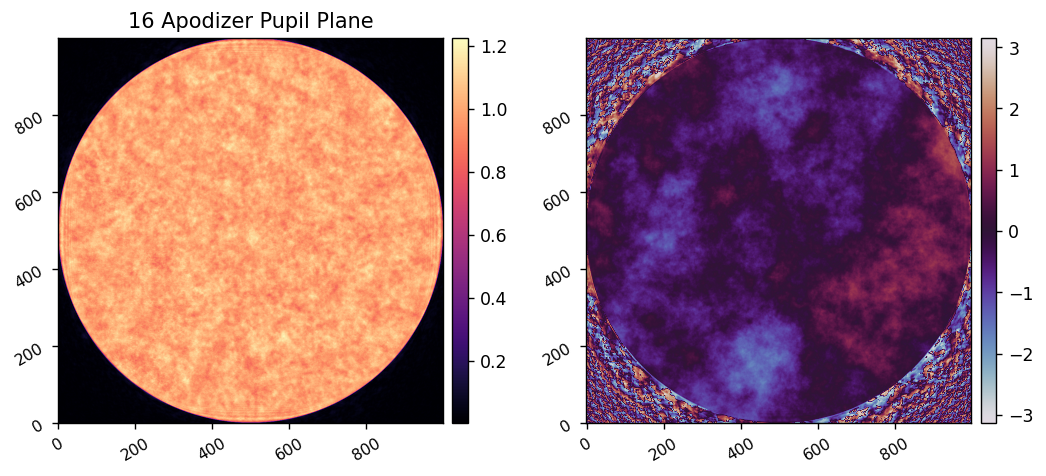

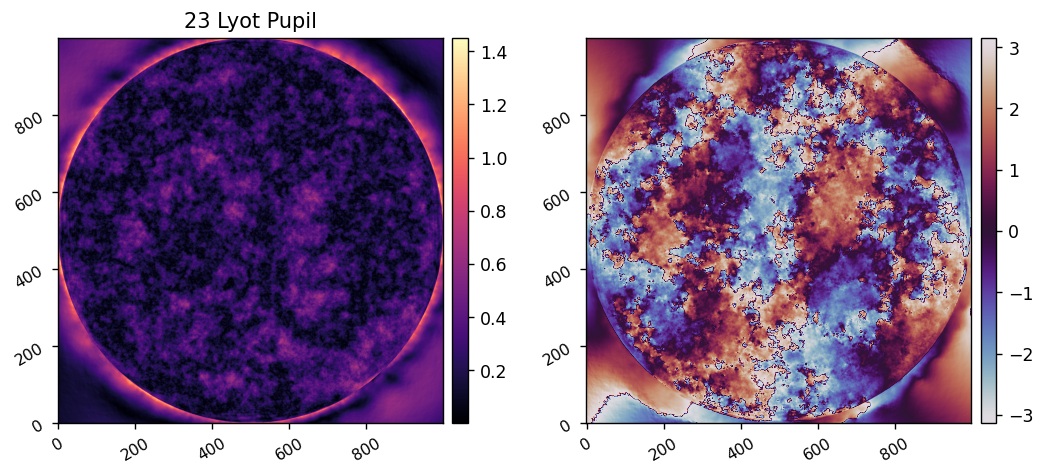

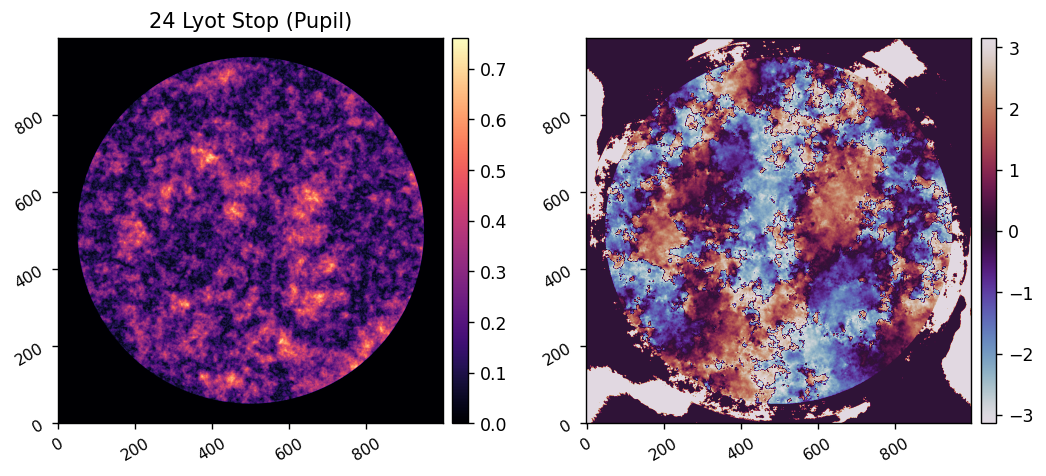

In [12]:
for i,wf in enumerate(wfs):
    if 'Pupil' in wf.location or 'DM' in wf.location:
        imshow2(wf.amplitude, wf.phase, f'{i:d} ' + wf.location[6:], npix=model.npix,
                cmap1='magma', cmap2='twilight')

In [92]:
reload(fresnel)
reload(apra_pop_models.props)
model = fresnel.CORO()
model.WFE.amplitude = ote_amp
model.WFE.opd = ote_opd
model.use_opds = True

model.return_lyot = True

lyot_amp, lyot_opd = model.calc_wf()

/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
influence function sampling 31.578947368421048
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


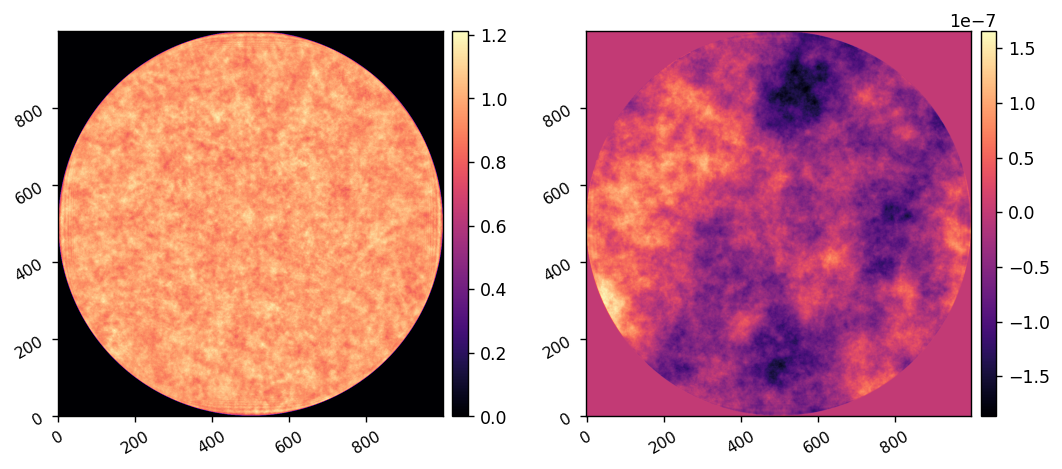

In [93]:
imshow2(lyot_amp, lyot_opd)

In [96]:
coro_data = xp.array([lyot_amp, lyot_opd])
utils.save_fits('../wfe-data/coro_wfe.fits', coro_data)

Saved data to:  ../wfe-data/coro_wfe.fits


In [ ]:
rms_amp = xp.sqrt(xp.mean(xp.square(coro_pupil[0][model.APMASK]-xp.mean(coro_pupil[0][model.APMASK]))))
rms_opd = xp.sqrt(xp.mean(xp.square(coro_pupil[1][model.APMASK])))


0.9702302396966975


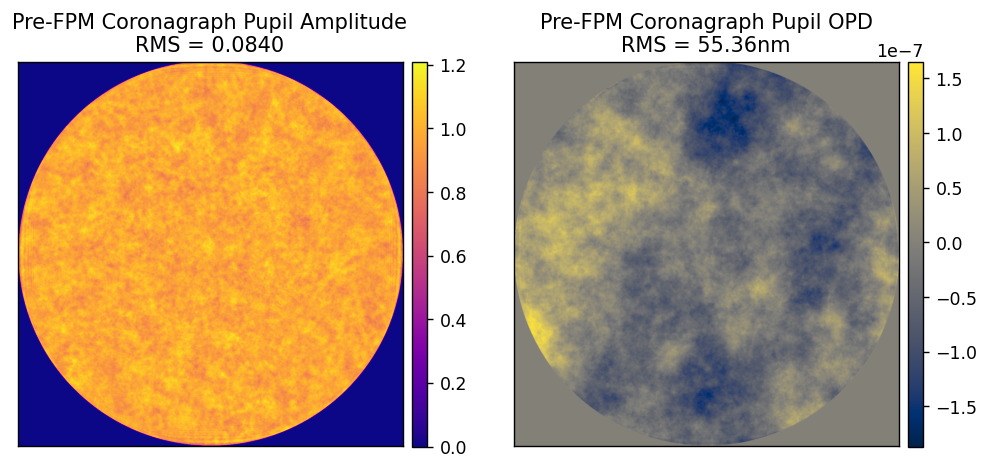

In [105]:
mean_amp = xp.mean(coro_data[0][model.APMASK])
print(mean_amp)
rms_amp = xp.sqrt(xp.mean(xp.square(coro_data[0][model.APMASK]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(coro_data[1][model.APMASK]))) * 1e9

fig, ax = imshow2(coro_data[0], coro_data[1], 
                  f'Pre-FPM Coronagraph Pupil Amplitude\nRMS = {rms_amp:.4f}', 
                  f'Pre-FPM Coronagraph Pupil OPD\nRMS = {rms_opd:.2f}nm', 
                  cmap1='plasma', cmap2='cividis', 
                  wspace=0.05,
                  return_fig=True, display_fig=False)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
display(fig)